In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
#from windrose import WindroseAxes

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

# from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


## Load data and preprocess

In [2]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch spectra, only have '17-'19
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

################################

## Functions

In [3]:
def minorticks():
    plt.rcParams['xtick.bottom'] = True # keep my tick marks
    plt.rcParams['ytick.left'] = True
    
## function to get relevant distances and significant wave heights
def get_dist_hs(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index, where inside the ice edge
    dist = dist[index]
    hs = insitu_dict[insitu].sigwaveheight[index]
    dist = dist[~np.isnan(hs)] # exclude nans for hist2d plots
    hs = hs[~np.isnan(hs)]
    return dist,hs

def get_dist_period(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    period = insitu_dict[insitu].peakwaveperiod[index]
    dist = dist[~np.isnan(period)] # exclude nans for hist2d plots
    period = period[~np.isnan(period)]
    return dist,period

def get_dist_Te(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Te = insitu_dict[insitu].Te[index]
    dist = dist[~np.isnan(Te)] # exclude nans for hist2d plots
    Te = Te[~np.isnan(Te)]
    return dist,Te

def get_dist_Te_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Te = insitu_dict[insitu].Te[index]
    dist = dist[~np.isnan(Te)] # exclude nans for hist2d plots
    Te = Te[~np.isnan(Te)]
    return dist,Te

def get_dist_Tp_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Tp = insitu_dict[insitu].peakwaveperiod[index]
    dist = dist[~np.isnan(Tp)] # exclude nans for hist2d plots
    Tp = Tp[~np.isnan(Tp)]
    return dist,Tp

def get_dist_hs_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    hs = insitu_dict[insitu].sigwaveheight[index]
    dist = dist[~np.isnan(hs)] # exclude nans for hist2d plots
    hs = hs[~np.isnan(hs)]
    return dist,hs

def get_wind_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    wind = insitu_dict[insitu].wind[index]
    dist = dist[~np.isnan(wind)] # exclude nans for hist2d plots
    wind = wind[~np.isnan(wind)] 
    return wind

def get_wind_dir_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    wind_dir = insitu_dict[insitu].wind_dir[index]
    dist = dist[~np.isnan(wind_dir)] # exclude nans for hist2d plots
    wind_dir = wind_dir[~np.isnan(wind_dir)] 
    return wind_dir

def get_peakdir_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    peakdir = insitu_dict[insitu].peakwavedirT[index]
    dist = dist[~np.isnan(peakdir)] # exclude nans for hist2d plots
    peakdir = peakdir[~np.isnan(peakdir)] 
    return peakdir

## sample code to find corresponding model cell to a latlon location
# templat = np.tile(sodaA.lat.values.mean(),
#                   cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
# templon = np.tile(sodaA.lon.values.mean(),
#                   cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
# difflat = templat - cice18.TLAT.values
# difflon = templon - cice18.TLON.values
# dist = difflat**2 + difflon**2
# np.where(dist == np.min(dist))

## Preprocessing

Resample in situ obs to 6-hour frequency (from 1 hour native frequency)

In [4]:
%%time

## resample
sodaA = sodaA.resample(time='6H').mean()
sodaB = sodaB.resample(time='6H').mean()
sodaC = sodaC.resample(time='6H').mean()
bgosA = bgosA.resample(time='6H').mean()
bgosD = bgosD.resample(time='6H').mean()

## exclude the nans
sodaA = sodaA.where(sodaA.sigwaveheight > 0, drop=True)
sodaB = sodaB.where(sodaB.sigwaveheight > 0, drop=True) 
sodaC = sodaC.where(sodaC.sigwaveheight > 0, drop=True) 
bgosA = bgosA.where(bgosA.sigwaveheight > 0, drop=True) 
bgosD = bgosD.where(bgosD.sigwaveheight > 0, drop=True) 

## repeat for swifts
for i,key in enumerate(swift_dict):
    swift_dict[key] = swift_dict[key].resample(time='6H').mean()
    swift_dict[key] = swift_dict[key].where(swift_dict[key].sigwaveheight > 0, drop=True)

CPU times: user 50 s, sys: 196 ms, total: 50.2 s
Wall time: 50.8 s


Interpolate distances to make one dataset that matches exactly the in situ obs timing.
Then create some dictionaries for ease of acccess.

In [5]:
%%time

alltimes = np.array([]) # make one array of all obs times
alltimes = np.hstack((bgosA.time.values,
                      bgosD.time.values,
#                       bds12.time.values, 
#                       bds15.time.values,
#                       bds17.time.values,
#                       bds18.time.values,
                      sodaA.time.values,
                      sodaB.time.values,
                      sodaC.time.values))

## add SWIFT data
for key,da in swift_dict.items():
    alltimes = np.hstack((alltimes,da.time.values))
    
alltimes = np.unique(np.sort(alltimes)) # times in ascending order, remove duplicates

## Uncomment this line when switching back to 6 hourly resample
dist_sat_interp = dist_sat_all.interp(time=alltimes)

CPU times: user 5.7 s, sys: 2.66 s, total: 8.37 s
Wall time: 9.24 s


In [13]:
## version with all obs, no resampling. 27 minutes!
# %%time
# dist_sat_interp = dist_sat_all.interp(time=alltimes)

CPU times: user 1min 11s, sys: 6min 24s, total: 7min 36s
Wall time: 27min 52s


In [37]:
## saved the version of in situ distances without resampling
# %%time
# new_filename = '~/scratch/waveice_analysis/dist_sat_interp_1hr.nc'
# print ('saving to ', new_filename)

# dist_sat_interp.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/dist_sat_interp_1hr.nc
finished saving
CPU times: user 311 ms, sys: 54.6 s, total: 54.9 s
Wall time: 3min 25s


In [11]:
## this is the 1 hour version; comment this out when using 6 hourly
# dist_sat_interp = xr.open_dataset('~/scratch/waveice_analysis/dist_sat_interp_1hr.nc')

In [6]:
%%time
## create dictionary of distances corresponding to obs
dist_dict = {}

cdr_dict = {}
cdr_dict['bgosA'] = dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).cdr
cdr_dict['bgosD'] = dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).cdr
cdr_dict['sodaA'] = dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).cdr
cdr_dict['sodaB'] = dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).cdr
cdr_dict['sodaC'] = dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).cdr

bt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).bt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).bt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).bt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).bt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).bt}

nt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).nt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).nt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).nt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).nt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).nt}

## optional addition of SWIFT data -- additional key for each buoy deployed
for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    
    ## insert the ice distances into the distance dictionaries
    cdr_dict[key] = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).cdr
    bt_dict[key]  = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).bt
    nt_dict[key]  = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).nt

dist_dict.update({'cdr' : cdr_dict,
                  'bt'  : bt_dict,
                  'nt'  : nt_dict})

# easy indexing of obs datasets
insitu_dict = {'sodaA' : sodaA,
               'sodaB' : sodaB,
               'sodaC' : sodaC,
               'bgosA' : bgosA,
               'bgosD' : bgosD,
              }

## SWIFT version already exists as swift_dict, but combine for ease with functions
for key,da in swift_dict.items():
    insitu_dict[key] = da

CPU times: user 261 ms, sys: 1.99 ms, total: 263 ms
Wall time: 262 ms


#### Add energy-weighted period to in situ data and wind (from JRA55 reanalysis)

##### Energy-weighted Period: $\frac{ \int f \cdot E(f)df}{ \int E(f)df}$

In [7]:
%%time

for key,val in insitu_dict.items():

    tempy = val.wavespectra_energy
    xfreq = val.freq_wavespectra.values
    
    tempy = tempy.where(tempy > 0, 0) # replace nans with zeros
    m0 = tempy.integrate(dim=tempy.dims[-1]) # area under spectral curve
    numerator = np.trapz(tempy * xfreq, xfreq)
    fe = numerator/m0 # energy weighted freq

    Te = 1./fe
    Te = Te.rename('Te')

    # also get the wind
    timekey = val.time.dt.round(freq='6H')
    uwnd = ww0019.uwnd.sel(ni=ni[key],nj=nj[key],time=timekey)
    vwnd = ww0019.vwnd.sel(ni=ni[key],nj=nj[key],time=timekey)
    wind = (np.sqrt(uwnd**2 + vwnd**2)).rename('wind')
    wind_dir = (np.arctan2(vwnd,uwnd)*180/np.pi).rename('wind_dir')
    
    wind['time'] = val.time.values
    wind_dir['time'] = val.time.values
    
    
    # let's add the CDR distance to the insitu dataset too to simplify
    cdr = dist_dict['cdr'][key]
    
    # update xarray
    insitu_dict[key] = xr.merge([val,Te,wind,wind_dir,cdr])

CPU times: user 9.28 s, sys: 310 ms, total: 9.59 s
Wall time: 26.3 s


# Spectra without resampling to 6-hour frequency

### BGOS + SODA

sodaA
sodaB
sodaC
bgosA
bgosD


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


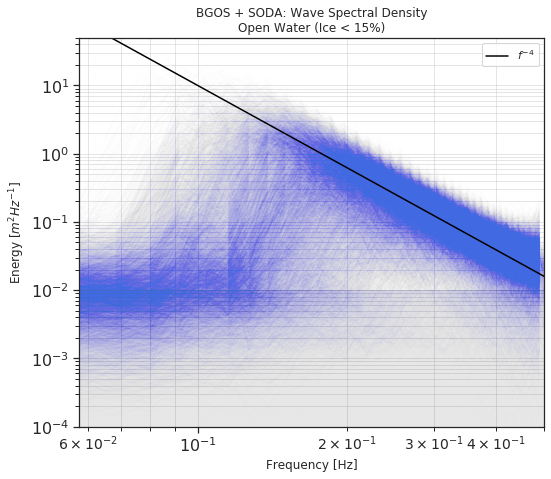

In [48]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.003,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


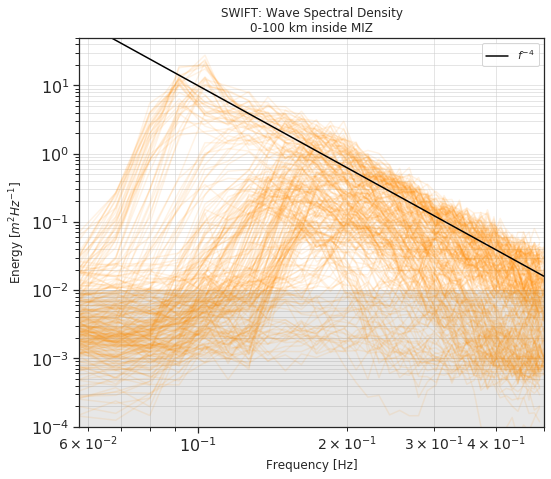

In [50]:
title = '0-100 km inside MIZ'
distmin = 0.0001
distmax = 100

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.1,add_legend=False,c='darkorange')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BOGS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


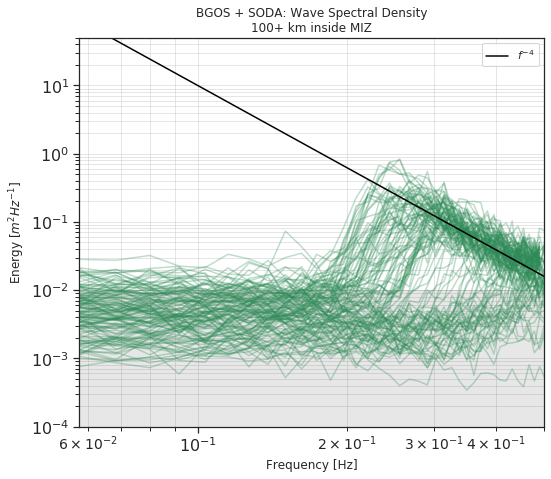

In [52]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.3,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

### SWIFT Data

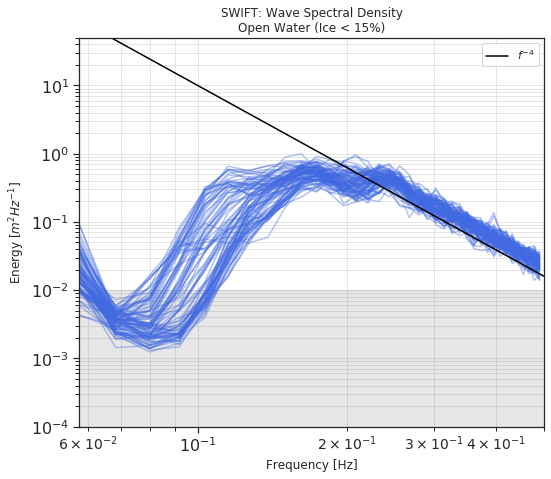

In [39]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

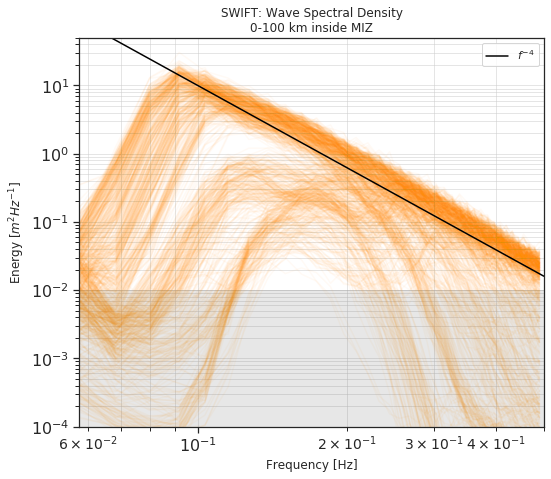

In [42]:
title = '0-100 km inside MIZ'
distmin = 0.0001
distmax = 100

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.04,add_legend=False,c='darkorange')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

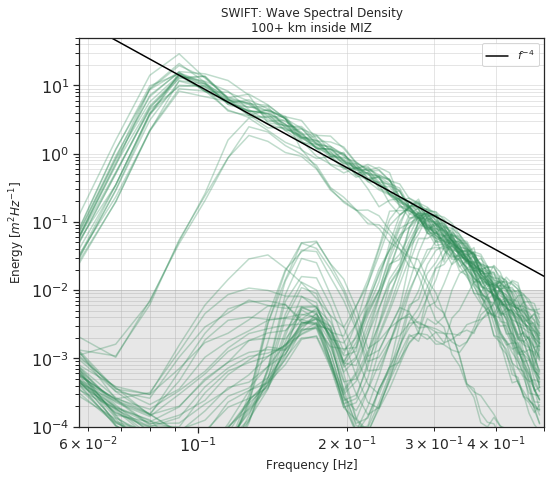

In [44]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.3,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

## Histogram of Significant Wave Height and Peak Period

In [133]:
## get the observations

month_limit = False
month_sel = 10
timeslice = slice('2012-01-01','2019-12-31')
# month_sel = 7 # choose true number of month (not python index at 0, so Jan = 1)
sat = 'cdr'

hs = np.array([])
fp = np.array([])
dist = np.array([])
hsmin = [] # dummy

hs_total = hs.copy() # array to hold all obs
fp_total = hs.copy() # array to hold all obs
dist_total = dist.copy() #  array to hold all obs

hs_threshold = 0.2

dist,hs = get_dist_hs(sat,'bgosA')
dist,fp = get_dist_period(sat,'bgosA')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'bgosD')
dist,fp = get_dist_period(sat,'bgosD')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaA')
dist,fp = get_dist_period(sat,'sodaA')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaB')
dist,fp = get_dist_period(sat,'sodaB')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaC')
dist,fp = get_dist_period(sat,'sodaC')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

## create separate totals
hstemp = hs_total[dist_total > 100]
hstemp_0 = hs_total[dist_total < .0001]
hstemp_0to100 = hs_total[(dist_total < 100) & (dist_total > 0)]
hstemp_100less = hs_total[dist_total < 100]

fptemp = fp_total[dist_total > 100]
fptemp_0 = fp_total[dist_total < .0001]
fptemp_0to100 = fp_total[(dist_total < 100) & (dist_total > 0)]
hstemp_100less = hs_total[dist_total < 100]

975 [0.10253083] 955
441 [0.10253083 0.10044342] 412
449 [0.10253083 0.10044342 0.1117777 ] 423
180 [0.10253083 0.10044342 0.1117777  0.13309572] 169
16 [0.10253083 0.10044342 0.1117777  0.13309572 0.28915935] 16


In [124]:
def hs_fp_bymon(month_sel):
    ## get the observations

    month_limit = True
#     month_sel = 10
    timeslice = slice('2012-01-01','2019-12-31')
    # month_sel = 7 # choose true number of month (not python index at 0, so Jan = 1)
    sat = 'cdr'

    hs = np.array([])
    fp = np.array([])
    dist = np.array([])
    hsmin = [] # dummy

    hs_total = hs.copy() # array to hold all obs
    fp_total = hs.copy() # array to hold all obs
    dist_total = dist.copy() #  array to hold all obs

    hs_threshold = 0.2

    dist,hs = get_dist_hs(sat,'bgosA')
    dist,fp = get_dist_period(sat,'bgosA')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'bgosD')
    dist,fp = get_dist_period(sat,'bgosD')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaA')
    dist,fp = get_dist_period(sat,'sodaA')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaB')
    dist,fp = get_dist_period(sat,'sodaB')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaC')
    dist,fp = get_dist_period(sat,'sodaC')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    ## create separate totals
    hstemp = hs_total[dist_total > 100]
    hstemp_0 = hs_total[dist_total < .0001]
    hstemp_0to100 = hs_total[(dist_total < 100) & (dist_total > 0)]
    hstemp_100less = hs_total[dist_total < 100]

    fptemp = fp_total[dist_total > 100]
    fptemp_0 = fp_total[dist_total < .0001]
    fptemp_0to100 = fp_total[(dist_total < 100) & (dist_total > 0)]
    hstemp_100less = hs_total[dist_total < 100]
    
    return(hstemp_0,fptemp_0)

## NOW FINISH COMPILING MONTHS FROM OBS

In [128]:
## group 6-8
obs_hs_melt_0 = np.array([])
obs_fp_melt_0 = np.array([])

temp1, temp2 = hs_fp_bymon(6)
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

temp1, temp2 = hs_fp_bymon(7)
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

temp1, temp2 = hs_fp_bymon(8)
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

########
## group 10 and 11
obs_hs_grow_0 = np.array([])
obs_fp_grow_0 = np.array([])

temp1, temp2 = hs_fp_bymon(6)
obs_hs_grow_0 = np.append(obs_hs_grow_0,temp1)
obs_fp_grow_0 = np.append(obs_fp_grow_0,temp2)

temp1, temp2 = hs_fp_bymon(7)
obs_hs_grow_0 = np.append(obs_hs_grow_0,temp1)
obs_fp_grow_0 = np.append(obs_fp_grow_0,temp2)

temp1, temp2 = hs_fp_bymon(8)
obs_hs_grow_0 = np.append(obs_hs_grow_0,temp1)
obs_fp_grow_0 = np.append(obs_fp_grow_0,temp2)

975 [0.41285881] 1
441 [0.41285881 0.10044342] 0
449 [0.41285881 0.10044342 0.15776753] 21
180 [0.41285881 0.10044342 0.15776753 0.20723106] 4
16 [0.41285881 0.10044342 0.15776753 0.20723106        nan] 0
975 [0.10253083] 19
441 [0.10253083 0.11050381] 2
449 [0.10253083 0.11050381 0.1201772 ] 107
180 [0.10253083 0.11050381 0.1201772  0.18323236] 0
16 [0.10253083 0.11050381 0.1201772  0.18323236 0.33248514] 7
975 [0.10754836] 277
441 [0.10754836 0.10126027] 113
449 [0.10754836 0.10126027 0.16282928] 122
180 [0.10754836 0.10126027 0.16282928 0.13309572] 66
16 [0.10754836 0.10126027 0.16282928 0.13309572 0.28915935] 8
975 [0.41285881] 1
441 [0.41285881 0.10044342] 0
449 [0.41285881 0.10044342 0.15776753] 21
180 [0.41285881 0.10044342 0.15776753 0.20723106] 4
16 [0.41285881 0.10044342 0.15776753 0.20723106        nan] 0


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:93: Runti

975 [0.10253083] 19
441 [0.10253083 0.11050381] 2
449 [0.10253083 0.11050381 0.1201772 ] 107
180 [0.10253083 0.11050381 0.1201772  0.18323236] 0
16 [0.10253083 0.11050381 0.1201772  0.18323236 0.33248514] 7
975 [0.10754836] 277
441 [0.10754836 0.10126027] 113
449 [0.10754836 0.10126027 0.16282928] 122
180 [0.10754836 0.10126027 0.16282928 0.13309572] 66
16 [0.10754836 0.10126027 0.16282928 0.13309572 0.28915935] 8


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:93: Runti

In [38]:
%%time

dist_plot = dist_model.sel(time=timeslice).where(
#     (dist_model.sel(time=timeslice) > 0) &
    (dist_model.sel(time=timeslice) > 100))

wave_plot_dist100 = xr.open_dataarray('./wave_plot_dist100.nc')
wave_plot_dist0 = xr.open_dataarray('~/scratch/waveice_analysis/wave_plot_dist0.nc')
wave_plot_dist0to100 = xr.open_dataarray('~/scratch/waveice_analysis/wave_plot_dist0to100.nc')
wave_plot_dist100less = xr.open_dataarray('./wave_plot_dist100less.nc')

freq_plot_dist100 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist100.nc')
freq_plot_dist0 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist0.nc')
freq_plot_dist0to100 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist0to100.nc')

if month_limit:
    dist_plot = dist_plot[(
        pd.DatetimeIndex(dist_plot.time.values).month == month_sel)]
    wave_plot_dist100 = wave_plot_dist100[(
        pd.DatetimeIndex(wave_plot_dist100.time.values).month == month_sel)]
    wave_plot_dist100less = wave_plot_dist100less[(
        pd.DatetimeIndex(wave_plot_dist100less.time.values).month == month_sel)]
    freq_plot_dist100 = freq_plot_dist100[(
        pd.DatetimeIndex(freq_plot_dist100.time.values).month == month_sel)]
    
# this method gets rid of all the nans
x = dist_plot.values[wave_plot_dist100 > 0.1]
y = wave_plot_dist100.values[wave_plot_dist100 > 0.1]
y_fp = freq_plot_dist100.values[wave_plot_dist100 > 0.1]

## Beaufort Chukchi region
# right now this only gets distance over 100km
dist_plot_beau = dist_plot.where(beau_mask)
dist_plot_beau100plus = dist_plot_beau.where(dist_plot_beau > 100)

## RETAIN ORDER OF LINES
## peak frequencies
beau_fp = freq_plot_dist100.where(beau_mask)
beau_fp_0 = freq_plot_dist0.where(beau_mask)
beau_fp_0to100 = freq_plot_dist0to100.where(beau_mask)

## significant wave heights
ybeau = wave_plot_dist100.where(beau_mask)
beau_hs = wave_plot_dist100.where(beau_mask)
beau_hs_0 = wave_plot_dist0.where(beau_mask)
beau_hs_0to100 = wave_plot_dist0to100.where(beau_mask)

## distances and waveheights, get rid of nans
xbeau = dist_plot_beau.values[ybeau > 0.1]
ybeau = ybeau.values[ybeau > 0.1]

## get rid of nans
vbeau_fp = beau_fp.values[(beau_fp > 0) & (beau_hs > 0.1)]
vbeau_hs = beau_hs.values[(beau_fp > 0) & (beau_hs > 0.1)]

vbeau_fp_0 = beau_fp_0.values[(beau_fp_0 > 0) & (beau_hs_0 > 0.1)]
vbeau_hs_0 = beau_hs_0.values[(beau_fp_0 > 0) & (beau_hs_0 > 0.1)]

vbeau_fp_0to100 = beau_fp_0to100.values[(beau_fp_0to100 > 0) & (beau_hs_0to100 > 0.1)]
vbeau_hs_0to100 = beau_hs_0to100.values[(beau_fp_0to100 > 0) & (beau_hs_0to100 > 0.1)]

CPU times: user 10.1 s, sys: 40.8 s, total: 50.9 s
Wall time: 2min 6s


In [135]:
%%time
## create model array for Oct-Nov
hsmin = 0.33
vbeau_fp_0_grow = np.array([])

ttemp = beau_fp_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 10) | (beau_fp_0.time.dt.month == 11)))
vbeau_fp_0_grow = ttemp.values[~np.isnan(ttemp)]

## create model array for Jun-Jul-Aug
vbeau_fp_0_melt = np.array([])
ttemp = beau_fp_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 6) | 
                        (beau_fp_0.time.dt.month == 7) | 
                        (beau_fp_0.time.dt.month == 8)))
vbeau_fp_0_melt = ttemp.values[~np.isnan(ttemp)]

CPU times: user 2.32 s, sys: 4.74 s, total: 7.06 s
Wall time: 11.4 s


### Creating peak frequency files for model data (binned by ice distance)

In [67]:
# %%time
# ## create peak frequency file
# freq_plot_dist100 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) > 100))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist100.nc'
# print ('saving to ', new_filename)
# freq_plot_dist100.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.7 s, sys: 8.81 s, total: 55.5 s
Wall time: 1min 57s


In [69]:
# %%time
# freq_plot_dist0to100 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) < 100) & 
#     (dist_model.sel(time=timeslice) > 0))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist0to100.nc'
# print ('saving to ', new_filename)
# freq_plot_dist0to100.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.3 s, sys: 9.68 s, total: 56 s
Wall time: 1min 14s


In [71]:
# %%time
# freq_plot_dist0 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) < 0.001))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist0.nc'
# print ('saving to ', new_filename)
# freq_plot_dist0.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.4 s, sys: 8.42 s, total: 54.9 s
Wall time: 1min 12s


In [36]:
# %%time
# wave_plot_dist0 = wave_plot_dist100less.where(dist_model.sel(time=timeslice) < 0.001)

# new_filename = '~/scratch/waveice_analysis/wave_plot_dist0.nc'
# print ('saving to ', new_filename)
# wave_plot_dist0.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/wave_plot_dist0.nc
finished saving
CPU times: user 618 ms, sys: 2.68 s, total: 3.29 s
Wall time: 7.74 s


In [37]:
# %%time
# wave_plot_dist0to100 = wave_plot_dist100less.where(dist_model.sel(time=timeslice) > 0)

# new_filename = '~/scratch/waveice_analysis/wave_plot_dist0to100.nc'
# print ('saving to ', new_filename)
# wave_plot_dist0to100.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/wave_plot_dist0to100.nc
finished saving
CPU times: user 588 ms, sys: 3.28 s, total: 3.86 s
Wall time: 9.56 s


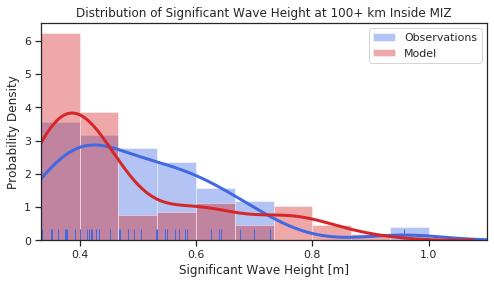

In [43]:
## post AGU, reduced model domain
## 1d histogram obs and model mixed
## BEAUFORT REGION
setmin = 0.3333333333
setmax = 1.0
nbins = 10
model_hs = vbeau_hs[vbeau_hs > setmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(hstemp[hstemp > setmin],bins=nbins,kde=True,rug=True,
                       color='royalblue',
                       label='Observations',
                       hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]})
    sns.distplot(model_hs,bins=nbins,kde=True,
                 color='tab:red',
                 label='Model',
                 hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Significant Wave Height [m]')
    plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,1.1)
    plt.legend()

    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


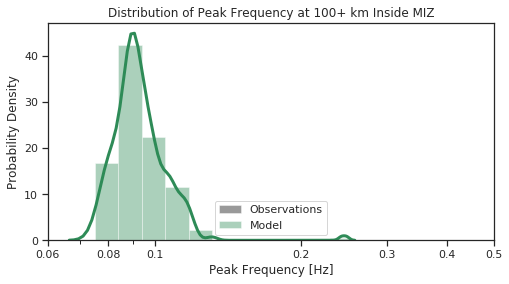

In [132]:
## 1d histogram obs and model
## BEAUFORT REGION
setmin = 6e-2
setmax = 0.5
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp[vbeau_hs > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp[hstemp>hsmin],bins=bins,kde=True,rug=True,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='seagreen',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency at 100+ km Inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

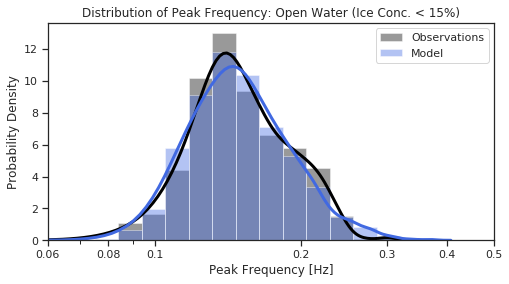

In [131]:
## 1d histogram obs and model
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0[vbeau_hs_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp_0[hstemp_0 > hsmin],bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

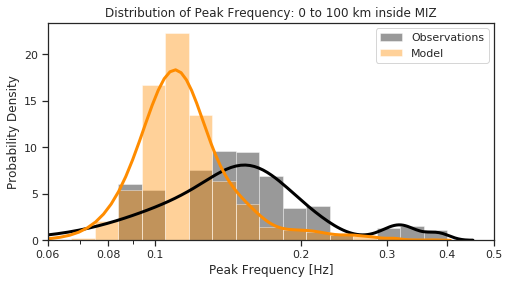

In [87]:
## 1d histogram obs and model
## peak frequency: 0 to 100
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0to100[vbeau_hs_0to100 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp_0to100[hstemp_0to100 > hsmin],bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='darkorange',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':0.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: 0 to 100 km inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

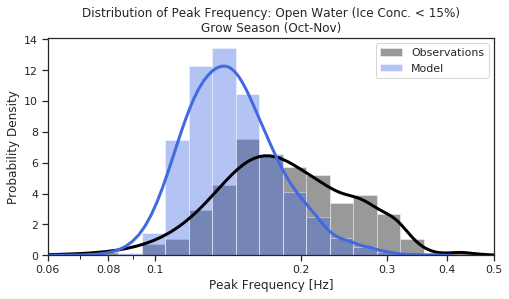

In [136]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_grow#[vbeau_hs_0_grow > hsmin]
obs_fp = obs_fp_grow_0[obs_hs_grow_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs_fp,bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nGrow Season (Oct-Nov)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

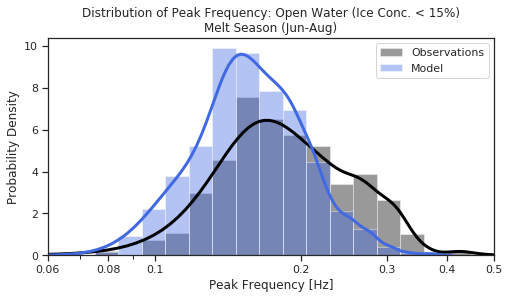

In [140]:
## melt season 6 7 8
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_melt
obs_fp = obs_fp_melt_0[obs_hs_melt_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs_fp,bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':0.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nMelt Season (Jun-Aug)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

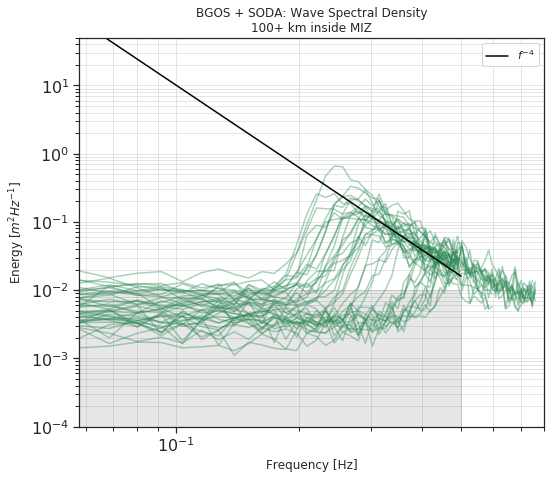

In [56]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#         if (key[0] == 'b'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.33))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.xlim(10**(-1.24),0.8)
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

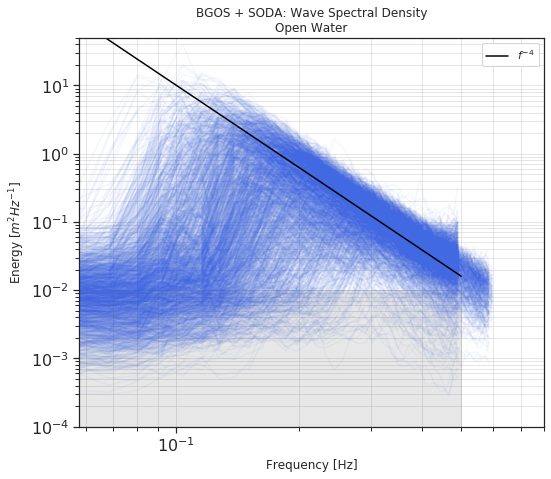

In [147]:
title = 'Open Water'
distmin = -1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#         if (key[0] == 'b'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.33))

            spectrum.plot.line(
                        hue='time',alpha=0.05,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.xlim(10**(-1.24),0.8)
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Model Spectra: open water only when waves are present

# ERA-5 Comparison